Plot Example Sign Map, Phase Contours, and Magnitude Heatmap for each Rearing Condition

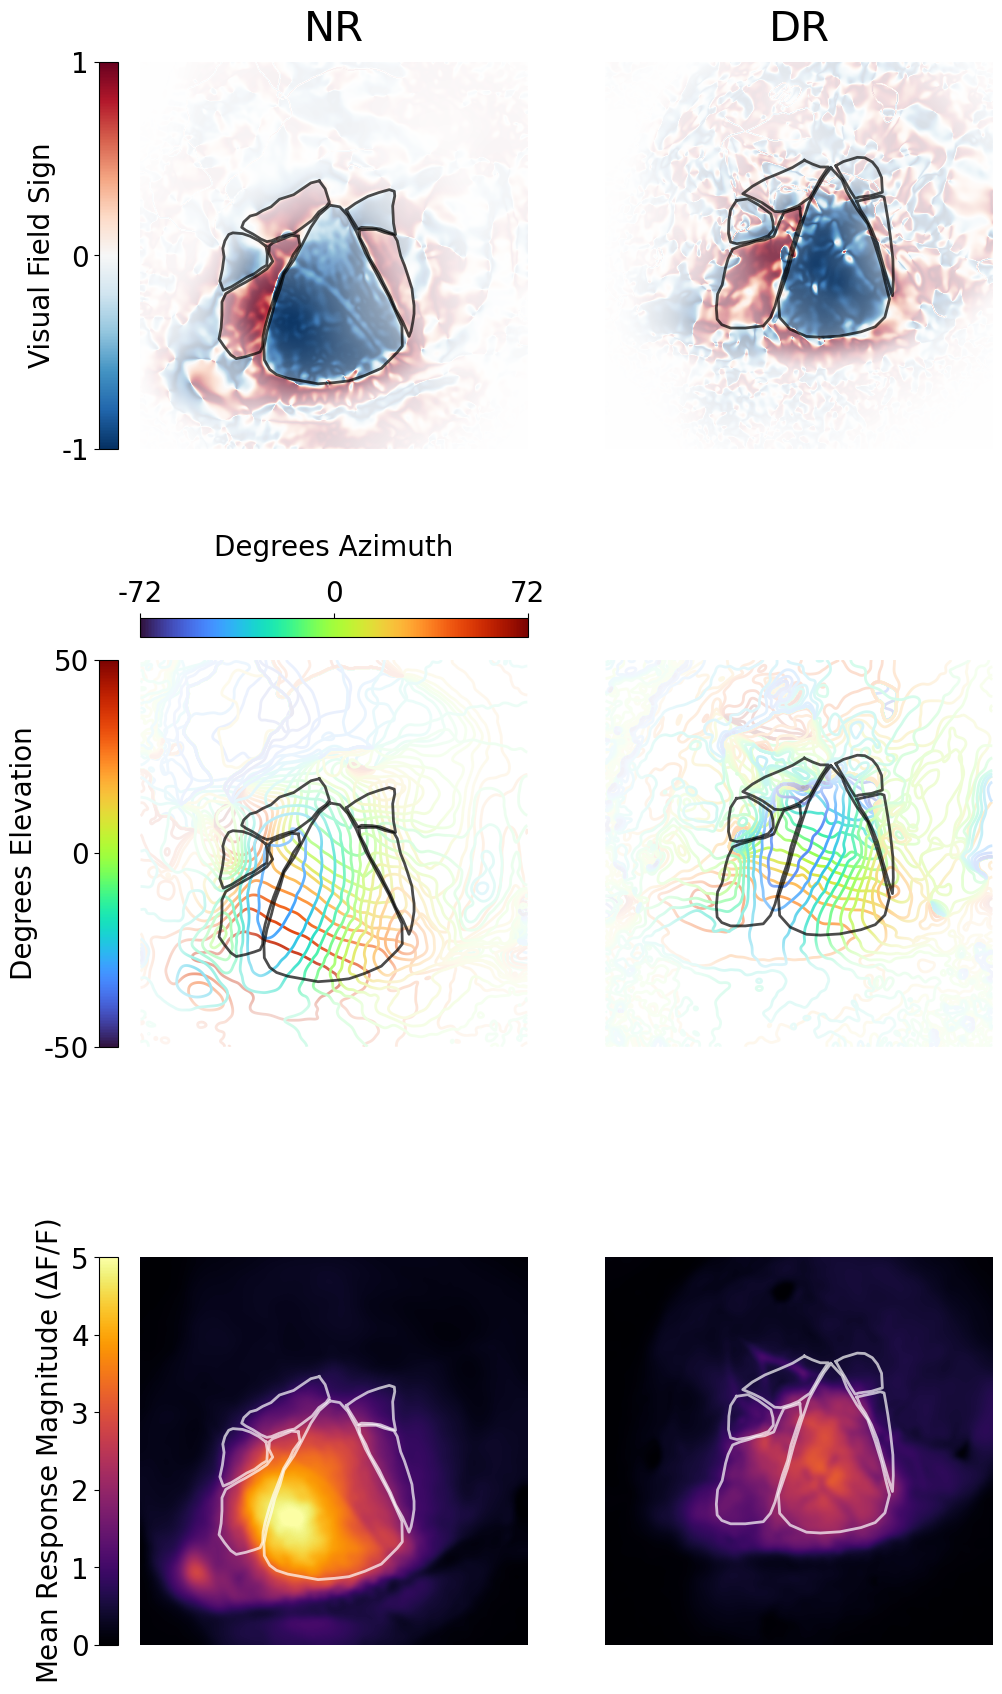

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from tifffile import imread
from skimage import filters

def draw_colorbar(mappable, cax, label="", num_ticks=6, width="5%", height="100%", loc="center left", frmt="%i", ori="vertical", label_pos="left"):
    cax = inset_axes(cax, width=width, height=height, loc=loc, borderpad=-3)
    colorbar = fig.colorbar(mappable, cax=cax, orientation=ori)
    colorbar.set_label(label, color='k', fontsize=20)
    colorbar.ax.locator_params(nbins=num_ticks)
    if ori == "vertical":
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position(label_pos)
        cax.yaxis.set_major_formatter(FormatStrFormatter(frmt))
    elif ori == "horizontal":
        cax.xaxis.tick_top()
        cax.xaxis.set_label_position(label_pos)
        cax.xaxis.set_major_formatter(FormatStrFormatter(frmt))
    cax.tick_params(labelsize=20)
    return colorbar

exp_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Mapping_Through_Skull/"
examples = ["ctb03/20220623_161247/", 
            "ctb01/20220603_101509/"]
area_list = ["V1", "LM", "AL", "RL", "AM", "PM"]
%matplotlib inline
fig, axs = plt.subplots(3, 2)
for ex_num, ex in enumerate(zip(examples, ["NR", "DR"])):
    ref_frame = imread(exp_path + ex[0] + "refframe.tif").squeeze()
    signmap = np.loadtxt(exp_path + ex[0] + "signmap.csv")
    azimuth = np.loadtxt(exp_path + ex[0] + "azimuth.csv")
    elevation = np.loadtxt(exp_path + ex[0] + "elevation.csv")
    avg_mag = np.loadtxt(exp_path + ex[0] + "avg_mag.csv")*100
    alphas = filters.gaussian((avg_mag/np.max(avg_mag)), 10)
    # Sign Map
    axs[0][ex_num].imshow(signmap, cmap="RdBu_r", alpha=1*alphas, clim=[-1, 1])
    axs[0][ex_num].axis("off")
    if ex_num == 0:
        draw_colorbar(axs[0][ex_num].images[0], axs[0][ex_num], label="Visual Field Sign", num_ticks=3)
    for area in area_list:
        area_coords = np.loadtxt(exp_path + ex[0] + area + ".csv")
        axs[0][ex_num].plot(area_coords[:,0], area_coords[:,1], color="k", linewidth=2, alpha=0.7)
    # Azimuth/Elevation
    axs[1][ex_num].imshow(elevation, cmap='turbo', alpha=1, clim=[0, 100], zorder=-3)
    axs[1][ex_num].imshow(azimuth, cmap='turbo_r', alpha=1, clim=[0, 144], zorder=-3)
    axs[1][ex_num].imshow(np.full((512, 512), 1), cmap="gray", clim=[0, 1], zorder=-2, alpha=1)
    axs[1][ex_num].contour(elevation, levels=np.arange(0, 100, 5), cmap='turbo', alpha=1, linewidths=2, zorder=-1)
    axs[1][ex_num].contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='turbo_r', alpha=1, linewidths=2, zorder=-1)
    axs[1][ex_num].imshow(np.full((512, 512), 1), cmap="gray", clim=[0, 1], zorder=1, alpha=0.95*(1-alphas))
    if ex_num == 0:
        cbar_az = draw_colorbar(axs[1][0].images[1], axs[1][0], num_ticks=3, width="100%", height="5%", loc="upper center", ori="horizontal", label_pos="top")
        cbar_az.ax.set_xticks([0, 72, 144])
        cbar_az.ax.set_xticklabels(["72", "0", "-72"])
        cbar_az.ax.invert_xaxis()
        axs[1][ex_num].set_title("Degrees Azimuth", fontsize=20, pad=75)
        cbar_el = draw_colorbar(axs[1][0].images[0], axs[1][0], label="Degrees Elevation", num_ticks=3, frmt="%i")
        cbar_el.ax.set_yticks([0, 50, 100])
        cbar_el.ax.set_yticklabels(["-50", "0", "50"])
    axs[1][ex_num].axis("off")
    for area in area_list:
        area_coords = np.loadtxt(exp_path + ex[0] + area + ".csv")
        axs[1][ex_num].plot(area_coords[:,0], area_coords[:,1], color="k", linewidth=2, alpha=0.7)
    # Magnitude
    axs[2][ex_num].imshow(avg_mag, cmap="inferno", alpha=1, clim=[0, 5])
    axs[2][ex_num].axis("off")
    for area in area_list:
        area_coords = np.loadtxt(exp_path + ex[0] + area + ".csv")
        axs[2][ex_num].plot(area_coords[:,0], area_coords[:,1], color="w", linewidth=2, alpha=0.7)
    if ex_num == 0:
        draw_colorbar(axs[2][ex_num].images[0], axs[2][ex_num], label="Mean Response Magnitude ($\Delta$F/F)", num_ticks=6)
    axs[0][ex_num].set_title(ex[1], fontsize=30, pad=15)
# Set figure parameters.
fig.set_size_inches(11, 22)
fig.savefig(exp_path + "example.png", bbox_inches="tight")

Plot Visual Field Sign STD and Average Magnitude Boxplots

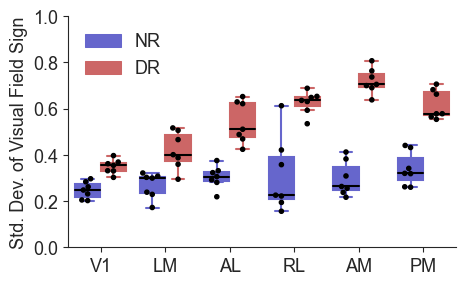

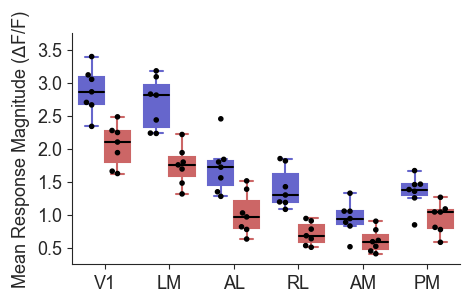

In [141]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from tifffile import imread
from os.path import exists
import pandas as pd
import seaborn as sb

# Load data.
data_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Mapping_Through_Skull/"

exp_info = {
            "ctb01": {"exp_name": "20220603_101509", "rearing": "DR"}, 
            "ctb02": {"exp_name": "20220610_105811", "rearing": "DR"},
            "ctb07": {"exp_name": "20220711_135556", "rearing": "DR"},
            "ctb08": {"exp_name": "20220715_121356", "rearing": "DR"},
            "lt168": {"exp_name": "20220330_130327", "rearing": "DR"},
            "lt169": {"exp_name": "20220420_125809", "rearing": "DR"},
            "lt170": {"exp_name": "20220421_133932", "rearing": "DR"},
            "ctb03": {"exp_name": "20220623_161247", "rearing": "NR"},
            "ctb04": {"exp_name": "20220630_130119", "rearing": "NR"},
            "ctb05": {"exp_name": "20220706_105937", "rearing": "NR"},
            "ctb09": {"exp_name": "20220720_153020", "rearing": "NR"},
            "lt171": {"exp_name": "20220427_115917", "rearing": "NR"},
            "lt172": {"exp_name": "20220428_130342", "rearing": "NR"},
            "lt175": {"exp_name": "20220512_124014", "rearing": "NR"}
            }

# Choose visual areas for segmentation.
area_list = ["V1", "LM", "AL", "RL", "AM", "PM"]

%matplotlib qt5
for ID,data in exp_info.items():
    # Load reference frame and sign map for segmenting
    exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
    data["signmap"] = np.loadtxt(exp_path + "signmap.csv")
    # Create dictionary for storing visual area boundary coordinates.
    data["area_coords"] = dict(zip(area_list, [None]*len(area_list)))
    for area_num,area in enumerate(area_list):
        data["area_coords"][area] = np.loadtxt(exp_path + "{ar}.csv".format(ar=area))
    # Also load average magnitude, azimuth, and elevation data for downstream analyses.
    data["avg_mag"] = np.loadtxt(exp_path + "avg_mag.csv")*100
    data["azimuth"] = np.loadtxt(exp_path + "azimuth.csv")
    data["elevation"] = np.loadtxt(exp_path + "elevation.csv")
    
exp_stats = pd.DataFrame(columns=["ID", "rearing", "visual_area", "signmap_std", "avg_mag"])

for ID,data in exp_info.items():
    exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
    for area in area_list:
        if not exists(exp_path + "{ar}_mask.csv".format(ar=area)):
            area_mask = np.full((512, 512), False)
            # Find points contained in current area boundary.
            area_path = mplPath.Path(data["area_coords"][area])
            for row in range(area_mask.shape[0]):
                for col in range(area_mask.shape[1]):
                    area_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
            np.savetxt(exp_path + "{ar}_mask.csv".format(ar=area), area_mask)
        else:
            area_mask = np.loadtxt(exp_path + "{ar}_mask.csv".format(ar=area))
        # Visual field sign STD
        sm_masked = data["signmap"].copy()
        sm_masked[area_mask == 0] = np.nan
        signmap_std = np.nanstd(sm_masked)
        # Average magnitude
        avg_mag = np.nanmean(data["avg_mag"][area_mask == 1])
        # Write to dataframe.
        exp_stats.loc[len(exp_stats.index)] = [ID, data["rearing"], area, signmap_std, avg_mag]
        
%matplotlib inline
plot_vars = ["signmap_std", "avg_mag"]
ylabs = ["Std. Dev. of Visual Field Sign", "Mean Response Magnitude ($\Delta$F/F)"]
ylims = [(0, 1),(0.25, 3.75)]
for plot_num, plot in enumerate(plot_vars):
    fig, ax = plt.subplots()
    bx = sb.boxplot(
                    ax=ax,
                    data=exp_stats, 
                    x="visual_area", 
                    y=plot,
                    hue="rearing",
                    hue_order=["NR", "DR"],
                    palette={"NR":(0.4, 0.4, 0.8), "DR":(0.8, 0.4, 0.4)},
                    saturation=1,
                    fliersize=0
                    )
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    for patch_num, patch in enumerate(box_patches):
        face_color = patch.get_facecolor()
        patch.set_edgecolor(face_color)
        for line_idx, line_num in enumerate(range(patch_num*6, patch_num*6+6)):
            line = ax.lines[line_num]
            if line_idx == 4:
                prev_color = face_color
                face_color = "k"
            elif line_idx > 4:
                face_color = prev_color
            line.set_color(face_color)
            line.set_mfc(face_color)
            line.set_mec(face_color)
    sb.swarmplot(
                 ax=ax,
                 data=exp_stats, 
                 x="visual_area", 
                 y=plot,
                 hue="rearing", 
                 hue_order=["NR", "DR"], 
                 dodge=True,
                 palette={"NR":"k", "DR":"k"},
                 size=3,
                 linewidth=1,
                 edgecolor="k",
                 native_scale=True
                )
    if plot_num > 0:
        ax.legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:2], labels=labels[0:2], frameon=False, loc="upper left", fontsize=13)
        for legend_patch in ax.legend_.get_patches():
            col = legend_patch.get_facecolor()
            legend_patch.set_edgecolor(col)
    bx.set_xlabel("")
    bx.set_ylabel(ylabs[plot_num], fontsize=13)
    bx.set(ylim=ylims[plot_num])
    bx.tick_params(labelsize=13)
    if plot_num == 1:
        bx.set_yticks(np.arange(0.5, 4, 0.5))
    sb.despine()
    sb.set_style("ticks")
    fig.set_size_inches(5, 3)
    fig.savefig(data_path + plot + ".png", dpi=500, bbox_inches="tight")

Plot Phase Histograms

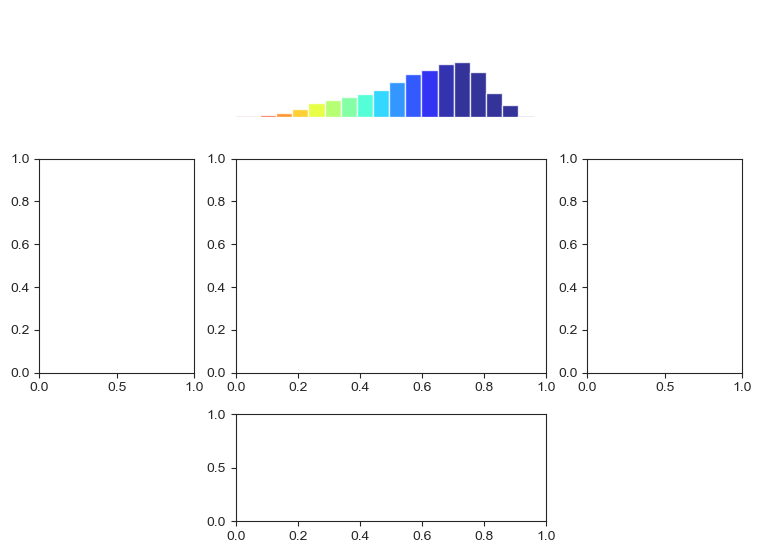

In [206]:
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from tifffile import imread
from os.path import exists
import pandas as pd
import seaborn as sb

# Load data.
data_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Mapping_Through_Skull/"

exp_info = {
            "ctb01": {"exp_name": "20220603_101509", "rearing": "DR"}, 
            "ctb02": {"exp_name": "20220610_105811", "rearing": "DR"},
            "ctb07": {"exp_name": "20220711_135556", "rearing": "DR"},
            "ctb08": {"exp_name": "20220715_121356", "rearing": "DR"},
            "lt168": {"exp_name": "20220330_130327", "rearing": "DR"},
            "lt169": {"exp_name": "20220420_125809", "rearing": "DR"},
            "lt170": {"exp_name": "20220421_133932", "rearing": "DR"},
            "ctb03": {"exp_name": "20220623_161247", "rearing": "NR"},
            "ctb04": {"exp_name": "20220630_130119", "rearing": "NR"},
            "ctb05": {"exp_name": "20220706_105937", "rearing": "NR"},
            "ctb09": {"exp_name": "20220720_153020", "rearing": "NR"},
            "lt171": {"exp_name": "20220427_115917", "rearing": "NR"},
            "lt172": {"exp_name": "20220428_130342", "rearing": "NR"},
            "lt175": {"exp_name": "20220512_124014", "rearing": "NR"}
            }

# Choose visual areas for segmentation.
area_list = ["V1", "LM", "AL", "RL", "AM", "PM"]

for ID,data in exp_info.items():
    # Load reference frame and sign map for segmenting
    exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
    data["signmap"] = np.loadtxt(exp_path + "signmap.csv")
    # Create dictionary for storing visual area boundary coordinates.
    data["area_coords"] = dict(zip(area_list, [None]*len(area_list)))
    for area_num,area in enumerate(area_list):
        data["area_coords"][area] = np.loadtxt(exp_path + "{ar}.csv".format(ar=area))
    # Also load average magnitude, azimuth, and elevation data for downstream analyses.
    data["avg_mag"] = np.loadtxt(exp_path + "avg_mag.csv")*100
    data["azimuth"] = np.loadtxt(exp_path + "azimuth.csv")
    data["elevation"] = np.loadtxt(exp_path + "elevation.csv")
    
exp_stats = pd.DataFrame(columns=["ID", "rearing", "visual_area", "azimuth", "elevation"])

%matplotlib inline
area_list = ["V1"]
for area in area_list:
    az = {"NR":np.empty((1,)), "DR":np.empty((1,))}
    el = {"NR":np.empty((1,)), "DR":np.empty((1,))}
    for ID,data in exp_info.items():
        exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
        if not exists(exp_path + "{ar}_mask.csv".format(ar=area)):
            area_mask = np.full((512, 512), False)
            # Find points contained in current area boundary.
            area_path = mplPath.Path(data["area_coords"][area])
            for row in range(area_mask.shape[0]):
                for col in range(area_mask.shape[1]):
                    area_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
            np.savetxt(exp_path + "{ar}_mask.csv".format(ar=area), area_mask)
        else:
            area_mask = np.loadtxt(exp_path + "{ar}_mask.csv".format(ar=area))
        # Get phase values in visual area.
        curr_az = data["azimuth"][area_mask == 1]
        curr_el = data["elevation"][area_mask == 1]
        # Write to dataframe.
        az[data["rearing"]] = np.concatenate((az[data["rearing"]], curr_az))
        el[data["rearing"]] = np.concatenate((el[data["rearing"]], curr_el))
    fig, ax = plt.subplots()
    dists = inset_axes(ax, width="50%", height="50%", loc="center", borderpad=-3)
    dists.syticks()
    in_ax_el_NR = inset_axes(ax, width="25%", height="50%", loc="center left", borderpad=-3)
    az_NR = inset_axes(ax, width="50%", height="25%", loc="upper center", borderpad=0)
    hist_bins = np.arange(0., 1.44, 0.075)
    cmap = plt.cm.jet_r
    colors = cmap(hist_bins)
    hist, bin_edges = np.histogram(az["NR"], np.arange(0, 144, 7.5))
    norm_hist = hist/np.sum(hist)
    az_NR.bar(bin_edges[:-1], norm_hist, color=colors, alpha=0.8, width=7.5)
    az_NR.set_xlim((0., 144.))
    az_NR.set_xticks([])
    az_NR.set_xticklabels([])
    az_NR.set_yticks([])
    az_NR.set_yticklabels([])
    az_NR.set_ylim([0, 0.25])
    az_NR.axis("off")
    in_ax_el_DR = inset_axes(ax, width="25%", height="50%", loc="center right", borderpad=-3)
    in_ax_az_DR = inset_axes(ax, width="50%", height="25%", loc="lower center", borderpad=-3)
    ax.remove()
    fig.set_size_inches(8, 5.56)
    # sb.displot(x=az["DR"], y=el["DR"], binwidth=(7.5, 5), color=(0.8, 0.4, 0.4))

In [201]:
0.695*8

5.56